# Introduction

For this analysis, my research question would be what factors are associated with COVID-19 infection rates in United States counties. I would be utilizing various datasets concerning county health information, county COVID-19 infection rates, county population densities, and state political affiliation. In turn, I would attempt to identify and evaluate risk factors connected to infection rates by doing multiple regression analysis. The resultant linear regression model would be used mainly for interpretation. The outcome of the study, if deemed to be insightful and significant, can be used to access a population's vulnerability to COVID-19 based on the community's characteristics from the reference point of United States counties.  

In [1]:
# Import necessary libraries 

import pandas as pd
import numpy as np 
import altair as alt
import statsmodels.formula.api as smf
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

alt.data_transformers.enable('json')

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


DataTransformerRegistry.enable('json')

# Data overview

Let's take a look at the datasets this analysis will be using. A few of them  are put together by crawling wiki pages. The rest are from what are provided officially.

In [2]:
# https://github.com/nytimes/covid-19-data
# Cumulative counts of coronavirus cases in the US at the county level
county_infection = pd.read_csv('relevant_data/us-counties.csv')

In [3]:
county_infection.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [4]:
county_infection.tail()

,date,county,state,fips,cases,deaths
126830,2020-05-08,Sublette,Wyoming,56035.0,3,0
126831,2020-05-08,Sweetwater,Wyoming,56037.0,19,0
126832,2020-05-08,Teton,Wyoming,56039.0,98,1
126833,2020-05-08,Uinta,Wyoming,56041.0,9,0
126834,2020-05-08,Washakie,Wyoming,56043.0,7,0


> The latest date of the data is May 8th, 2020.

In [5]:
# https://en.wikipedia.org/wiki/County_(United_States)
# County population and density
county_population = pd.read_csv('relevant_data/county-population.csv')

In [6]:
county_population.head()

,state,county,population,land_area_km,density_km
0,Alabama,Autauga,54571,1540,35.436
1,Alabama,Baldwin,182265,4118,44.261
2,Alabama,Barbour,27457,2292,11.979
3,Alabama,Bibb,22915,1612,14.215
4,Alabama,Blount,57322,1670,34.325


In [7]:
# https://en.wikipedia.org/wiki/Political_party_strength_in_U.S._states
# State party affiliation based on house representation
state_party_line = pd.read_csv('relevant_data/state_party_line.csv')

In [8]:
state_party_line.head()

,state,state_house_blue_perc
0,Alabama,22.86
1,Alaska,35.00
2,Arizona,43.33
3,Arkansas,25.71
4,California,72.50


In [9]:
# Source: https://www.countyhealthrankings.org/
# Access: https://app.namara.io/#/data_sets/579ee1c6-8f66-418c-9df9-d7b5b618c774?organizationId=5ea77ea08fb3bf000c9879a1
# County health information
county_health = pd.read_csv('relevant_data/us-county-health-rankings-2020.csv')

In [10]:
county_health.head()

,fips,state,county,num_deaths,years_of_potential_life_lost_rate,95percent_ci_low,95percent_ci_high,quartile,ypll_rate_aian,ypll_rate_aian_95percent_ci_low,...,percent_hispanic,num_non_hispanic_white,percent_non_hispanic_white,num_not_proficient_in_english,percent_not_proficient_in_english,95percent_ci_low_39,95percent_ci_high_39,percent_female,num_rural,percent_rural
0,1000,Alabama,NaN,81791.0,9942.794666,9840.535949,10045.053384,NaN,NaN,NaN,...,4.443264,3197324,65.413428,48517,1.061048,1.006759,1.115337,51.633032,1957932.0,40.963183
1,1001,Alabama,Autauga,791.0,8128.591190,7283.340731,8973.841649,1.0,NaN,NaN,...,2.965774,41316,74.308016,426,0.820225,0.347891,1.292558,51.448715,22921.0,42.002162
2,1003,Alabama,Baldwin,2967.0,7354.122530,6918.554269,7789.690790,1.0,NaN,NaN,...,4.646779,181201,83.111337,1068,0.543517,0.347271,0.739763,51.538377,77060.0,42.279099
3,1005,Alabama,Barbour,472.0,10253.573403,8782.217281,11724.929524,2.0,NaN,NaN,...,4.276355,11356,45.641252,398,1.631683,0.824903,2.438462,47.216752,18613.0,67.789635
4,1007,Alabama,Bibb,471.0,11977.539484,10344.064842,13611.014126,3.0,NaN,NaN,...,2.625000,16708,74.589286,57,0.268210,0.000000,0.807504,46.781250,15663.0,68.352607


In [11]:
county_health.columns[:75]

Index(['fips', 'state', 'county', 'num_deaths',
       'years_of_potential_life_lost_rate', '95percent_ci_low',
       '95percent_ci_high', 'quartile', 'ypll_rate_aian',
       'ypll_rate_aian_95percent_ci_low', 'ypll_rate_aian_95percent_ci_high',
       'ypll_rate_asian', 'ypll_rate_asian_95percent_ci_low',
       'ypll_rate_asian_95percent_ci_high', 'ypll_rate_black',
       'ypll_rate_black_95percent_ci_low', 'ypll_rate_black_95percent_ci_high',
       'ypll_rate_hispanic', 'ypll_rate_hispanic_95percent_ci_low',
       'ypll_rate_hispanic_95percent_ci_high', 'ypll_rate_white',
       'ypll_rate_white_95percent_ci_low', 'ypll_rate_white_95percent_ci_high',
       'percent_fair_or_poor_health', '95percent_ci_low_2',
       '95percent_ci_high_2', 'quartile_2',
       'average_number_of_physically_unhealthy_days', '95percent_ci_low_3',
       '95percent_ci_high_3', 'quartile_3',
       'average_number_of_mentally_unhealthy_days', '95percent_ci_low_4',
       '95percent_ci_high_4', 'quar

> This dataset contains extensive information about a county's health, including the rankings, quantiles, rates, and percentages of numerous demographic as well as health qualities. Of the many measurements of each quality, we probably only need one or two to avoid duplication. In addition, I will do a **factor analysis** on the columns to see if it makes sense.

For more information about these columns, please visit this [info](https://app.namara.io/#/data_sets/579ee1c6-8f66-418c-9df9-d7b5b618c774/info?organizationId=5ea77ea08fb3bf000c9879a1) page

# Data wrangling

In this section, we want to prepare our data for further exploration and analysis. 

In [12]:
# Aggregate data related to county infection and basic characteristics
county = county_infection.merge(
    county_population, left_on=['county', 'state'], right_on=['county', 'state']
).merge(
    state_party_line, left_on=['state'], right_on=['state']
)

In [13]:
county.sample(5)

,date,county,state,fips,cases,deaths,population,land_area_km,density_km,state_house_blue_perc
63299,2020-04-09,Big Stone,Minnesota,27011.0,1,0,5269,1287,4.094,47.76
50849,2020-05-05,McMinn,Tennessee,47107.0,106,2,52266,1114,46.917,15.15
72816,2020-04-03,Newberry,South Carolina,45071.0,5,0,38079,1676,22.720,41.30
87417,2020-04-04,Winn,Louisiana,22127.0,2,0,15313,2479,6.177,30.77
14155,2020-03-27,Montgomery,Texas,48339.0,46,0,570934,2704,211.144,38.71


Let's look at the statistics of the counted days for the counties

In [14]:
# Count the number of days each county data has
def count_days(series):
    time_series = pd.to_datetime(series)
    first_date = time_series.iloc[0]
    last_date = time_series.iloc[-1]
    
    return (last_date - first_date).days + 1

In [15]:
grouped_county = county.groupby(['state', 'county']).agg(days_counted=('date', count_days))

In [16]:
grouped_county.describe()

,days_counted
count,2750.000000
mean,43.852000
std,12.192866
min,1.000000
25%,38.000000
50%,45.000000
75%,51.000000
max,109.000000


In [17]:
grouped_county.shape

(2750, 1)

We have 2750 counties in the data. The minimum amount of days counted for a county is only one, while the maximum is about two and a half months. I am happy that the median is a month and a half. Ideally, I want all counties in the analysis to have at least two months worth of data so that any of its heath characteristics can have a decent chance of exerting its influence if there is any at all. With the current data and analysis, I will only include counties with at least a month and a half worth of data to maximize the representativeness of the eventual infection picture and not exclude too much data. Please understand that I'm not a domain expert and don't have access to any. I apologize that this cutoff point seems rather arbitrary, but I hope the rationale at least somewhat makes sense domain-wise.

With that said, for the next step, we want to group the infection data by counties and create a bunch of aggregated columns including counted days, confirmed infection in the percentage of county population, death rate, and raw infection counts. We will also calculate those columns for the cutoff point of 45 days so that we can do the analysis without accounting for the number of days for model simplicity.

In [18]:
# Find the value at the 45 day mark
def county_cumulative_days(series, days = 45):
    # This may not be 100% accurate because perhaps some days are missing, 
    # but that seems to happen rarely.
    if len(series) < days:
        return series.iloc[-1]
    else:
        return series.iloc[days - 1]

In [19]:
# Group our data in terms of county and aggregate some columns to show overall infection rate 
# and death rate as well as at the 45 day mark
def group_county_data(data):
    grouped_data = data.groupby(['state', 'county']).agg(
        population=('population', lambda x: x.iloc[-1]),
        density_km=('density_km', lambda x: x.iloc[-1]),
        state_house_blue_perc=('state_house_blue_perc', lambda x: x.iloc[-1]),
        days_counted=('date', count_days),
        case_sum=('cases', lambda x: x.iloc[-1]),
        death_sum=('deaths', lambda x: x.iloc[-1]),
        case_count_45_days=('cases', county_cumulative_days),
        death_count_45_days=('deaths', county_cumulative_days)
    )
    
    grouped_data = grouped_data[grouped_data['days_counted'] >= 45]
    grouped_data['infection_rate'] = grouped_data['case_sum']/grouped_data['population']*100
    grouped_data['death_rate'] = grouped_data['death_sum']/grouped_data['case_sum']*100
    grouped_data = grouped_data[grouped_data['infection_rate'] != float("inf")]
    grouped_data['infection_rate_45_days'] = grouped_data['case_count_45_days']/grouped_data['population']*100
    grouped_data['death_rate_45_days'] = grouped_data['death_count_45_days']/grouped_data['case_count_45_days']*100
    
    return grouped_data.reset_index()

In [20]:
grouped_county = group_county_data(county)

In [21]:
grouped_county.sample(5)

,state,county,population,density_km,state_house_blue_perc,days_counted,case_sum,death_sum,case_count_45_days,death_count_45_days,infection_rate,death_rate,infection_rate_45_days,death_rate_45_days
454,Iowa,Scott,165224,139.312,36.00,48,276,8,255,7,0.167046,2.898551,0.154336,2.745098
373,Illinois,Will,677560,312.528,67.80,54,3561,199,2369,148,0.525562,5.588318,0.349637,6.247362
782,Missouri,Scott,39191,35.955,29.41,50,78,5,76,2,0.199025,6.410256,0.193922,2.631579
1169,South Dakota,Meade,25434,2.829,14.29,45,3,0,3,0,0.011795,0.000000,0.011795,0.000000
890,New York,St. Lawrence,111944,15.322,63.49,48,187,2,178,2,0.167048,1.069519,0.159008,1.123596


Next, let's tackle county health data.

Take a quick look over the data again.

In [22]:
county_health.sample(5)

,fips,state,county,num_deaths,years_of_potential_life_lost_rate,95percent_ci_low,95percent_ci_high,quartile,ypll_rate_aian,ypll_rate_aian_95percent_ci_low,...,percent_hispanic,num_non_hispanic_white,percent_non_hispanic_white,num_not_proficient_in_english,percent_not_proficient_in_english,95percent_ci_low_39,95percent_ci_high_39,percent_female,num_rural,percent_rural
1909,36097,New York,Schuyler,268.0,7035.709445,5554.089442,8517.329448,3.0,NaN,NaN,...,1.864672,16997,94.891693,48,0.281080,0.000000,0.776212,50.145154,14886.0,81.153574
649,17081,Illinois,Jefferson,596.0,9464.989180,8266.386576,10663.591784,4.0,NaN,NaN,...,2.797462,32318,85.452142,118,0.329821,0.055903,0.603738,48.580116,22819.0,58.770958
2233,40131,Oklahoma,Rogers,1269.0,7357.043086,6713.321951,8000.764222,1.0,8023.69015,6335.790181,...,4.878022,65813,71.548313,631,0.738003,0.541223,0.934783,50.142416,43709.0,50.295150
2651,48169,Texas,Garza,72.0,5329.338219,3621.026757,7564.570201,1.0,NaN,NaN,...,52.371542,2602,39.556096,1240,20.601429,16.533937,24.668921,33.794466,1443.0,22.334004
251,8003,Colorado,Alamosa,206.0,9380.536672,7634.099847,11126.973497,4.0,NaN,NaN,...,45.807109,8065,48.342624,640,4.186838,2.204479,6.169196,49.883115,5694.0,36.866300


In [23]:
county_health.columns

Index(['fips', 'state', 'county', 'num_deaths',
       'years_of_potential_life_lost_rate', '95percent_ci_low',
       '95percent_ci_high', 'quartile', 'ypll_rate_aian',
       'ypll_rate_aian_95percent_ci_low',
       ...
       'percent_hispanic', 'num_non_hispanic_white',
       'percent_non_hispanic_white', 'num_not_proficient_in_english',
       'percent_not_proficient_in_english', '95percent_ci_low_39',
       '95percent_ci_high_39', 'percent_female', 'num_rural', 'percent_rural'],
      dtype='object', length=507)

In [24]:
county_health.columns[:100]

Index(['fips', 'state', 'county', 'num_deaths',
       'years_of_potential_life_lost_rate', '95percent_ci_low',
       '95percent_ci_high', 'quartile', 'ypll_rate_aian',
       'ypll_rate_aian_95percent_ci_low', 'ypll_rate_aian_95percent_ci_high',
       'ypll_rate_asian', 'ypll_rate_asian_95percent_ci_low',
       'ypll_rate_asian_95percent_ci_high', 'ypll_rate_black',
       'ypll_rate_black_95percent_ci_low', 'ypll_rate_black_95percent_ci_high',
       'ypll_rate_hispanic', 'ypll_rate_hispanic_95percent_ci_low',
       'ypll_rate_hispanic_95percent_ci_high', 'ypll_rate_white',
       'ypll_rate_white_95percent_ci_low', 'ypll_rate_white_95percent_ci_high',
       'percent_fair_or_poor_health', '95percent_ci_low_2',
       '95percent_ci_high_2', 'quartile_2',
       'average_number_of_physically_unhealthy_days', '95percent_ci_low_3',
       '95percent_ci_high_3', 'quartile_3',
       'average_number_of_mentally_unhealthy_days', '95percent_ci_low_4',
       '95percent_ci_high_4', 'quar

There are 507 columns. To reiterate my proposed course of action, we want to first get rid of many different measurements of the same quality and only keep the rates. We also want to remove some redundant columns such as population. The purpose is to hopefully keep the complexity under a managable level, while maintaining the values.

In [25]:
excluded_column_words = [
    'quartile',
    'ci_high',
    'ci_low',
    'fips',
    'num',
    'denominator',
    'ratio',
    'population',
]

In [26]:
filtered_columns = county_health.columns[~county_health.columns.str.contains('|'.join(excluded_column_words))]

In [27]:
print(str(len(filtered_columns)) + ' columns remain!')

190 columns remain!


In [28]:
filtered_county_health = county_health[filtered_columns]

Next, let's merge the health data into the infection data, and check out the merged data.

In [29]:
county = grouped_county.merge(
    filtered_county_health, left_on=['county', 'state'], right_on=['county', 'state']
)

In [30]:
county

,state,county,population,density_km,state_house_blue_perc,days_counted,case_sum,death_sum,case_count_45_days,death_count_45_days,...,percent_65_and_over,percent_black,percent_american_indian_alaska_native,percent_asian,percent_native_hawaiian_other_pacific_islander,percent_hispanic,percent_non_hispanic_white,percent_not_proficient_in_english,percent_female,percent_rural
0,Alabama,Autauga,54571,35.436,22.86,46,67,4,61,3,...,15.562670,19.343177,0.480207,1.224798,0.111509,2.965774,74.308016,0.820225,51.448715,42.002162
1,Alabama,Baldwin,182265,44.261,22.86,56,208,5,168,3,...,20.443350,8.783976,0.772399,1.150343,0.066966,4.646779,83.111337,0.543517,51.538377,42.279099
2,Alabama,Blount,57322,34.325,22.86,45,44,0,44,0,...,18.236515,1.462656,0.653527,0.319848,0.121024,9.571231,86.886238,1.724520,50.726141,89.951502
3,Alabama,Butler,20947,10.411,22.86,45,162,3,162,3,...,20.299797,44.557927,0.376016,1.316057,0.050813,1.509146,51.255081,0.494155,53.429878,71.232157
4,Alabama,Calhoun,118572,75.572,22.86,52,123,3,93,3,...,17.717476,20.850215,0.539916,0.964324,0.110258,3.910673,72.024992,0.991376,51.946586,33.696826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,Wyoming,Natrona,78621,5.684,10.00,50,48,0,48,0,...,15.395311,1.161600,1.466220,0.827909,0.098591,8.581179,86.599254,0.731123,49.617645,14.449304
1458,Wyoming,Park,28702,1.596,10.00,53,1,0,1,0,...,23.206247,0.682035,0.944619,0.821852,0.057973,5.623380,90.915291,0.627835,50.194380,44.240383
1459,Wyoming,Sheridan,29596,4.529,10.00,59,16,0,16,0,...,20.993616,0.797142,1.366057,0.823603,0.112460,4.342937,91.482817,0.348727,49.793272,35.478775
1460,Wyoming,Sweetwater,45267,1.676,10.00,46,19,0,19,0,...,12.111217,1.145153,1.544680,1.010429,0.157952,16.083250,79.312908,1.633221,48.544749,10.916313


We have a lot of columns. Perhaps a lot of them have missing data for more than half of the data. We have no reasonable and accessible way of dealing with missing data here. We could fill in missing values from nearby counties, but that could be both erroneous and difficult. As a result, we will simply get rid of missing data in terms of columns and rows. Let's deal with columns first because we want to keep as many as rows as possible.

In [31]:
# Let's see the columns at near 90% cutoff points
county.dropna(thresh=1300, axis=1).info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1462 entries, 0 to 1461
Data columns (total 90 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   state                                               1462 non-null   object 
 1   county                                              1462 non-null   object 
 2   population                                          1462 non-null   int64  
 3   density_km                                          1462 non-null   float64
 4   state_house_blue_perc                               1462 non-null   float64
 5   days_counted                                        1462 non-null   int64  
 6   case_sum                                            1462 non-null   int64  
 7   death_sum                                           1462 non-null   int64  
 8   case_count_45_days                                  1462 non-null   int64  
 9

At the 90% row number cutoff point, it seems like we have a managable amount of columns. But we still have a few columns with disproportionately more missing data than the rest. Some examples are the suicide rate, firearm fatality rate, and crude rate. With that said, we will set the cutoff point at 1390 rows(95%) to keep the column, percent_enrolled_in_free_or_reduced_lunch, because that information seems useful. Given that I am not a domain export, I hope that decision makes sense.

In [32]:
county.dropna(thresh=1390, axis=1).dropna()

,state,county,population,density_km,state_house_blue_perc,days_counted,case_sum,death_sum,case_count_45_days,death_count_45_days,...,percent_65_and_over,percent_black,percent_american_indian_alaska_native,percent_asian,percent_native_hawaiian_other_pacific_islander,percent_hispanic,percent_non_hispanic_white,percent_not_proficient_in_english,percent_female,percent_rural
0,Alabama,Autauga,54571,35.436,22.86,46,67,4,61,3,...,15.562670,19.343177,0.480207,1.224798,0.111509,2.965774,74.308016,0.820225,51.448715,42.002162
1,Alabama,Baldwin,182265,44.261,22.86,56,208,5,168,3,...,20.443350,8.783976,0.772399,1.150343,0.066966,4.646779,83.111337,0.543517,51.538377,42.279099
2,Alabama,Blount,57322,34.325,22.86,45,44,0,44,0,...,18.236515,1.462656,0.653527,0.319848,0.121024,9.571231,86.886238,1.724520,50.726141,89.951502
3,Alabama,Butler,20947,10.411,22.86,45,162,3,162,3,...,20.299797,44.557927,0.376016,1.316057,0.050813,1.509146,51.255081,0.494155,53.429878,71.232157
4,Alabama,Calhoun,118572,75.572,22.86,52,123,3,93,3,...,17.717476,20.850215,0.539916,0.964324,0.110258,3.910673,72.024992,0.991376,51.946586,33.696826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,Wyoming,Laramie,94483,13.581,10.00,53,163,1,145,1,...,16.028128,2.417758,1.169981,1.365988,0.134376,14.795506,78.501859,0.823311,49.310944,19.784604
1457,Wyoming,Natrona,78621,5.684,10.00,50,48,0,48,0,...,15.395311,1.161600,1.466220,0.827909,0.098591,8.581179,86.599254,0.731123,49.617645,14.449304
1458,Wyoming,Park,28702,1.596,10.00,53,1,0,1,0,...,23.206247,0.682035,0.944619,0.821852,0.057973,5.623380,90.915291,0.627835,50.194380,44.240383
1459,Wyoming,Sheridan,29596,4.529,10.00,59,16,0,16,0,...,20.993616,0.797142,1.366057,0.823603,0.112460,4.342937,91.482817,0.348727,49.793272,35.478775


We are keeping a decent amount of data. Let's go ahead with that decision.

In [33]:
county = county.dropna(thresh=1390, axis=1).dropna()

# Factor analysis

After data wrangling, we are still dealing with a large number of columns. If we continue with our anaylsis as is, it might suffer from the curse of dimensionality. Also, if we are to include interaction terms, the number of parameters could get close to the number of rows. Furthermore, there is a high chance that we will run into multicollinearity. For all these reaons, I have decided to run factor anaylsis as the next step to reduce dimensionality and find independant latent variables. Please refer to its [wiki](https://en.wikipedia.org/wiki/Factor_analysis) for more information on the technique itself.

In [34]:
# List the columns again for an overview
county.columns

Index(['state', 'county', 'population', 'density_km', 'state_house_blue_perc',
       'days_counted', 'case_sum', 'death_sum', 'case_count_45_days',
       'death_count_45_days', 'infection_rate', 'death_rate',
       'infection_rate_45_days', 'death_rate_45_days',
       'years_of_potential_life_lost_rate', 'percent_fair_or_poor_health',
       'percent_low_birthweight', 'percent_smokers',
       'percent_adults_with_obesity', 'food_environment_index',
       'percent_physically_inactive',
       'percent_with_access_to_exercise_opportunities',
       'percent_excessive_drinking',
       'percent_driving_deaths_with_alcohol_involvement', 'chlamydia_rate',
       'teen_birth_rate', 'percent_uninsured', 'primary_care_physicians_rate',
       'dentist_rate', 'mental_health_provider_rate',
       'preventable_hospitalization_rate', 'percent_with_annual_mammogram',
       'percent_vaccinated', 'high_school_graduation_rate',
       'percent_some_college', 'labor_force', 'percent_unemployed'

In [35]:
# Exclude columns that won't be used as explanatory variables and can't used in factor analysis
excluded_columns = [
    'state',
    'county', 
    'population',
    'state_house_blue_perc',
    'days_counted', 
    'case_sum', 
    'death_sum', 
    'case_count_45_days',
    'death_count_45_days', 
    'infection_rate', 
    'death_rate',
    'infection_rate_45_days', 
    'death_rate_45_days',
    'presence_of_water_violation' # The only boolean field left in the health columns
]

In [36]:
county_non_factor = county[excluded_columns]

In [37]:
county_factor = county.drop(excluded_columns, axis=1)

Let's check whether factor anaylsis is appropriate first. We will be using [Bartlett’s Test](https://en.wikipedia.org/wiki/Bartlett's_test) and [Kaiser-Meyer-Olkin Test](https://www.statisticshowto.com/kaiser-meyer-olkin/). The former is used to access whether or not the variables intercorrelate. The latter measures the suitability of data for factor analysis.

In [38]:
chi_square_value, p_value = calculate_bartlett_sphericity(county_factor)

In [39]:
chi_square_value, p_value

(130054.64856585019, 0.0)

The test was staistically significant, indicating that there is no homoscedasticity among the variables. 

In [40]:
kmo_all, kmo_model = calculate_kmo(county_factor)

In [41]:
kmo_model

0.8828786882215096

This score indicates that the data is excellent for factor analysis.

Let's start with 30 factors and check out their eigenvalues.

In [42]:
fa = FactorAnalyzer()

# Using the varimax rotation because it makes it easier to identify each variable with a single factor and
# it is commonly used for research purposes.
fa.set_params(n_factors=25, rotation='varimax')
fa.fit(county_factor)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=25, rotation='varimax',
               rotation_kwargs={}, use_smc=True)

In [43]:
ev, v = fa.get_eigenvalues()
ev[:30]

array([21.13639691,  9.39768251,  5.27989301,  4.08270828,  2.59835808,
        2.14835316,  1.97495021,  1.82425098,  1.3702138 ,  1.3240699 ,
        1.31690975,  1.12089484,  1.04680272,  0.97908155,  0.87884346,
        0.8314389 ,  0.77623467,  0.68345863,  0.65110675,  0.61791411,
        0.56775113,  0.55405291,  0.52345115,  0.4702066 ,  0.45241334,
        0.44064763,  0.42775042,  0.40428229,  0.39054013,  0.37446732])

In [44]:
ev[30:]

array([3.69711705e-01, 3.44002156e-01, 3.19890049e-01, 2.99770192e-01,
       2.85559892e-01, 2.76776440e-01, 2.59086659e-01, 2.36973356e-01,
       2.29289371e-01, 2.16089677e-01, 2.14278245e-01, 1.95693042e-01,
       1.79803758e-01, 1.70126542e-01, 1.67248197e-01, 1.59202760e-01,
       1.44998313e-01, 1.40222175e-01, 1.38866503e-01, 1.22996335e-01,
       1.14750366e-01, 1.00145429e-01, 9.81685145e-02, 8.12711614e-02,
       6.89362234e-02, 6.76870526e-02, 6.65872877e-02, 4.93324053e-02,
       4.62042124e-02, 4.25054957e-02, 3.99040695e-02, 3.45745590e-02,
       2.25302763e-02, 2.10177907e-02, 1.61617769e-02, 1.05485160e-02,
       2.51391677e-03, 6.09612969e-04, 4.91395244e-04, 3.49432813e-04])

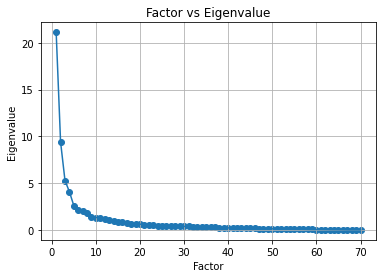

In [45]:
plt.scatter(range(1, len(ev)+1),ev)
plt.plot(range(1, len(ev)+1),ev)
plt.title('Factor vs Eigenvalue')
plt.xlabel('Factor')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

It seems like we have 13 factors that are significant(bigger than one).

In [46]:
fa = FactorAnalyzer()
fa.set_params(n_factors=13, rotation='varimax')
fa.fit(county_factor)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=13, rotation='varimax',
               rotation_kwargs={}, use_smc=True)

In [47]:
factor_loading = pd.DataFrame(fa.loadings_)

In [48]:
factor_loading.index = county_factor.columns

In [49]:
factor_loading.shape

(70, 13)

In [50]:
factor_loading

,0,1,2,3,4,5,6,7,8,9,10,11,12
density_km,-0.193155,0.098851,0.157345,0.154863,0.125308,-0.055280,0.354861,0.013059,0.197064,0.031165,0.076436,0.539116,0.018087
years_of_potential_life_lost_rate,0.879258,-0.135793,-0.103860,0.224081,0.013504,0.059297,0.011367,-0.046120,0.022192,0.142893,0.198389,-0.098410,-0.015700
percent_fair_or_poor_health,0.827442,0.288438,0.099535,0.189564,-0.070118,0.163714,-0.057063,0.107781,0.183516,0.032865,0.052879,0.000832,0.117056
percent_low_birthweight,0.589735,-0.070587,0.074225,0.595951,0.004613,0.094204,0.016461,0.012799,0.047232,-0.130797,0.078606,0.027024,0.081994
percent_smokers,0.801156,-0.229642,-0.104279,0.052872,-0.024987,-0.079376,-0.057220,0.100367,0.175454,0.059913,-0.035154,-0.045283,0.143206
...,...,...,...,...,...,...,...,...,...,...,...,...,...
percent_hispanic,-0.086688,0.853850,0.138695,-0.064159,-0.018022,0.256068,0.115612,0.073598,-0.089515,-0.023603,0.036140,0.000654,0.102451
percent_non_hispanic_white,-0.186161,-0.578872,-0.264259,-0.600268,0.022444,-0.220539,-0.143452,-0.190746,0.052868,-0.092681,-0.090587,-0.123354,-0.101335
percent_not_proficient_in_english,-0.121761,0.866553,0.205097,-0.008101,0.017351,0.163431,0.183637,0.059159,0.072858,0.016083,-0.030443,0.144654,0.012033
percent_female,0.051995,-0.069605,0.099916,0.356953,0.269870,0.005303,0.112756,-0.114124,0.224327,0.009884,0.105121,-0.194619,-0.061862


Now that we have collected all the significant factors, let's interpret them one by one.